# Method Comparison - SVM and kNN for a Spam Filter

In this scenario, I have mined mails using the GMAIL API. Out of the 171 mails mined, I took 100 from the inbox and the rest 71 from the spam section. I then converted the data into a CSV with code snippets, subject, date, sender and type (ham or spam). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  

In [2]:
df_spam = pd.read_csv('File_path')
#Catagorize this as spam
df_spam['Type'] = 'spam'
df_ham = pd.read_csv('File_path')
#Catagorize this as ham
df_ham['Type'] = 'ham'
frames = [df_spam, df_ham]
df_train = pd.concat(frames)
print(df_train.columns)

Index(['Sender', 'Subject', 'Date', 'Snippet', 'Message_body', 'Type'], dtype='object')


In [3]:
df_train.shape

(182, 6)

## Visualizing the data
I have now examined the data in the form of a bar chart and pie chart to understand the data set composition. Here, I have more ham data than spam. However, I have included a significant amount of spam to ensure that the algorithm trains well. I have also looked at the most common words in the messages in spam and ham to get an idea of what constitutes spam and ham.

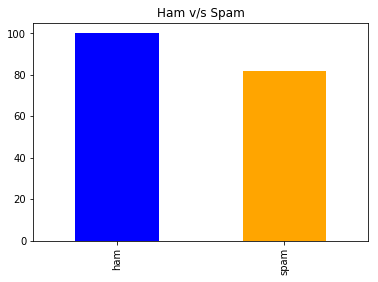

In [4]:
count_Class=pd.value_counts(df_train["Type"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Ham v/s Spam')
plt.show()

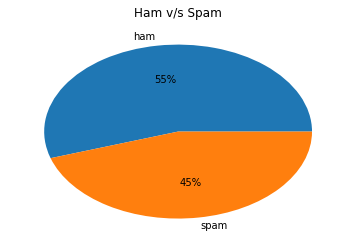

In [34]:
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Ham v/s Spam')
plt.ylabel('')
plt.show()

In [6]:
count1 = Counter(" ".join(df_train[df_train['Type']=='ham']["Snippet"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(df_train[df_train['Type']=='spam']["Snippet"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

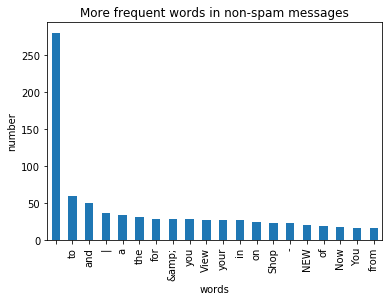

In [7]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

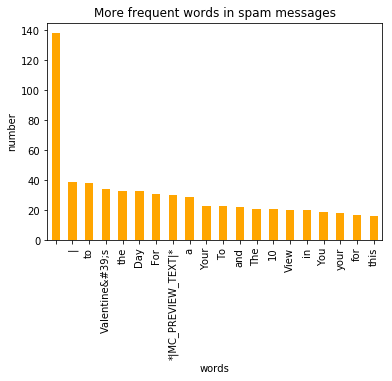

In [8]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()


## Data Cleaning
I have then cleaned the data to remove stopwords. I have also converted all the words into lower case and removed punctutation, to ensure that I have only text data. I have then developed a word frequency matrix.

In [9]:
f = feature_extraction.text.CountVectorizer(analyzer=u'word',
    stop_words = 'english',lowercase=True,strip_accents='ascii')
        
X = f.fit_transform(df_train["Snippet"])
np.shape(X)

(182, 1402)

## Test - Train split
I have now divided the data into test and train. Its a 67% train versus 33% test data split. I have also randomized the data to reduce bias in sampling. 

In [10]:
df_train["Type"]=df_train["Type"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                   df_train['Type'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(121, 1402), (61, 1402)]


# Using Naive Bayes
I have now implemented Naive Bayes to classify the data into spam and otherwise. I have iterated over the regularization term alpha to check for the optimal value. I am feeding a bag of words constituting snippets of the email. I have then identified the number of false positives and true negatives to measure the effeciency of this algorithm. 
The formula used here is : 
Pr(Spam|Word)= Pr(Word | Spam).Pr(Spam) / Pr(Word | Spam)* Pr(Spam) * Pr(Word | Ham) * Pr(Ham) 

However, Naive Bayes has several disadvantages : It is pretty simplistic in its assumptions and is heavily reliant on training data. 



In [11]:
list_alpha = np.arange(1/100000, 20, 0.11) #Iterate over the alpha value 
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

In [12]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.975207,0.770492,0.629630,0.809524
1,0.11001,0.975207,0.672131,0.666667,0.620690
2,0.22001,0.975207,0.672131,0.666667,0.620690
3,0.33001,0.975207,0.672131,0.666667,0.620690
4,0.44001,0.975207,0.672131,0.666667,0.620690
5,0.55001,0.975207,0.672131,0.666667,0.620690
6,0.66001,0.975207,0.672131,0.666667,0.620690
7,0.77001,0.975207,0.672131,0.666667,0.620690
8,0.88001,0.975207,0.672131,0.666667,0.620690
9,0.99001,0.975207,0.672131,0.666667,0.620690


In [13]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             0.000010
Train Accuracy    0.975207
Test Accuracy     0.770492
Test Recall       0.629630
Test Precision    0.809524
Name: 0, dtype: float64

In [14]:
#Between these models with the highest possible precision, 
#we are going to select which has more test accuracy. 
#In this case precision = 0.809524 
best_index = models[models['Test Precision']>0.8]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             0.000010
Train Accuracy    0.975207
Test Accuracy     0.770492
Test Recall       0.629630
Test Precision    0.809524
Name: 0, dtype: float64

In [15]:
#Building a confusion matrix using the model withe highest accuracy and precision
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
TP = m_confusion_test[1, 1]
TN = m_confusion_test[0, 0]
FP = m_confusion_test[0, 1]
FN = m_confusion_test[1, 0]
pd.DataFrame(data = m_confusion_test, columns = ['Predicted spam - 0', 'Predicted ham - 1'],
            index = ['Actual spam - 0', 'Actual ham - 1'])



,Predicted spam - 0,Predicted ham - 1
Actual spam - 0,30,4
Actual ham - 1,10,17


From the confusion matrix, we observe that using this model:
We misclassified 10 spam emails as non-spam emails and misclassified 4 non-spam emails as spam emails.

In [16]:
#Classification Accuracy: 
#Overall, how often is the classifier correct?
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, bayes.predict(X_test)))

0.770491803279
0.770491803279


The accuracy for this model is about 78%

In [17]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test,bayes.predict(X_test)))

0.62962962963
0.62962962963


Sensitivity, is to check the true positive rate, i.e., to check how sensitive is the classifier to detectng positive instances, or when the actual value is positive, how often is it corrrect ?

In this scenario, it is 0.63 which means the classifier is moderatley sensitive. 


In [18]:
specificity = TN / (TN + FP)

print(specificity)

0.882352941176


Looking at the specificity of the classifier, we check, when the actual value is negative, how often is the prediction correct ?

The classifier in this case is highly specific. 

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, bayes.predict(X_test)))

             precision    recall  f1-score   support

          0       0.75      0.88      0.81        34
          1       0.81      0.63      0.71        27

avg / total       0.78      0.77      0.77        61



In [20]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.117647058824
0.117647058824


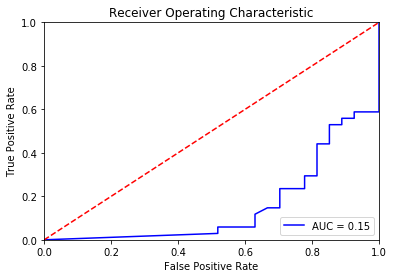

In [21]:
#y_score_bayes = bayes.fit(X_train, y_train).decision_function(X_test)
y_true = y_test
#y_probas = svc.predict_proba(X_test)[:,1]
y_pred = bayes.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=0)

roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



I have also calculated the precion, recall and false positive rate of the classifier as well as plotting the ROC Curve. The reason behind this, is that false positives are considered more costly than false negatives, and by calculating precision which takes false postive as its variable, it shows us the filter's safety performance. And by calculating the false positive rate, we can can have a good idea on the evaluation of the classifier. I have calculated recall, to measure the percentage of spam emails that the filter manages to block, giving us the filter's efficiency metric. I have also calculated the F-measure, which is the weighted harmonic mean of precision and recall. 

We observe that, the accuracy of the model is about 78%, with moderate sensitivity and highly specific. It has a spam precision of 75% and recall of 88%. It's false positive rate is 11%. The F-measure is 77%. The AUC from the ROC curve is very low at 0.15. 

# Using SVMs 
SVM's map the data from an input space to a high-dimensional feature space. And then find the optimal hyperplane with maimum margin between the 2 classes. SVM's are considered optimal for spam filtering since they are unsupervised and develop hypothesis using a subset of the data. However SVM, has a disadvantage: the SVM may choose the same kind of hypothesis which reduces its learning performance. 


In [22]:
#We train different models changing the regularization parameter C.
#We evaluate the accuracy, recall and precision of the model with the test set.
list_C = np.arange(500, 2000, 100) #100000
score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, y_train)
    score_train[count] = svc.score(X_train, y_train)
    score_test[count]= svc.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test))
    count = count + 1 

In [23]:
#Let's see the first 10 learning models and their metrics!
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,0.983471,0.721311,0.481481,0.8125
1,600.0,0.983471,0.721311,0.481481,0.8125
2,700.0,0.983471,0.721311,0.481481,0.8125
3,800.0,0.983471,0.721311,0.481481,0.8125
4,900.0,0.983471,0.721311,0.481481,0.8125
5,1000.0,0.983471,0.704918,0.444444,0.8000
6,1100.0,0.983471,0.704918,0.444444,0.8000
7,1200.0,0.983471,0.704918,0.444444,0.8000
8,1300.0,0.983471,0.704918,0.444444,0.8000
9,1400.0,0.983471,0.704918,0.444444,0.8000


In [24]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

C                 500.000000
Train Accuracy      0.983471
Test Accuracy       0.721311
Test Recall         0.481481
Test Precision      0.812500
Name: 0, dtype: float64

In [25]:
models[models['Test Precision']>0.8].head(n=5)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,0.983471,0.721311,0.481481,0.8125
1,600.0,0.983471,0.721311,0.481481,0.8125
2,700.0,0.983471,0.721311,0.481481,0.8125
3,800.0,0.983471,0.721311,0.481481,0.8125
4,900.0,0.983471,0.721311,0.481481,0.8125


In [26]:
best_index = models[models['Test Precision']>0.8]['Test Accuracy'].idxmax()
svc = svm.SVC(C=list_C[best_index],probability=True)
svc.fit(X_train, y_train)
models.iloc[best_index, :]


C                 500.000000
Train Accuracy      0.983471
Test Accuracy       0.721311
Test Recall         0.481481
Test Precision      0.812500
Name: 0, dtype: float64

In [27]:
m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(X_test))
TP = m_confusion_test[1, 1]
TN = m_confusion_test[0, 0]
FP = m_confusion_test[0, 1]
FN = m_confusion_test[1, 0]
pd.DataFrame(data = m_confusion_test, columns = ['Predicted spam ', 'Predicted ham '],
            index = ['Actual spam ', 'Actual ham ' ])



,Predicted spam,Predicted ham
Actual spam,31,3
Actual ham,14,13


From the confusion matrix, we observe that using this model:
We misclassified 14 spam as non-spam emails and 3 non-spam emails as spam emails.

In [28]:
#Classification Accuracy: 
#Overall, how often is the classifier correct?
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, svc.predict(X_test)))

0.72131147541
0.72131147541


The accuracy for this model is about 72%

In [29]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test,svc.predict(X_test)))

0.481481481481
0.481481481481


The sensitivity of the classifier is moderate to low, i.e., its true positive rate is moderate. 

In [30]:
specificity = TN / (TN + FP)

print(specificity)

0.911764705882


The classifier is highly specific, which means it is good at predicting mails as spam. 

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.69      0.91      0.78        34
          1       0.81      0.48      0.60        27

avg / total       0.74      0.72      0.71        61



In [32]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.0882352941176
0.0882352941176


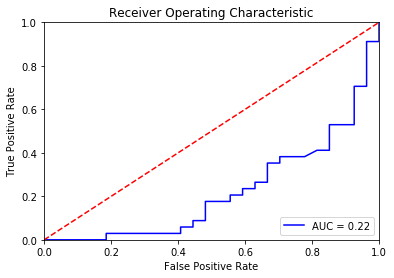

In [33]:
y_score_svc = svc.fit(X_train, y_train).decision_function(X_test)
y_true = y_test
#y_probas = svc.predict_proba(X_test)[:,1]
y_pred = svc.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=0)

roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Using the same reasons, as with Naive Bayes, the evaluation metrics I have calculated to measure the performance , are the precision, recall and false positive rate of the classifier as well as plotting the ROC Curve. I have also calculated the F-measure, sensitivity and specificity , and accuracy of the model to evalute the performance of the SVM model as with Naive bayes.  

We observe that, the accuracy of the model is about 72%, with moderate to low sensitivity and highly specific. It has a spam precision of 69% and recall of 91%. It's false positive rate is 9%. The F-measure is 71%. The AUC from the ROC curve is quite low at 0.22.

## Conclusion
Both the classifiers did not show 100% precision or accuracy, and have similar values for both the measures, with Naive Bayes having a slightly higher accuracy. The SVM classifier is slightly more specific, and the naive bayes classifier has a slightly higher precision. The SVM model has a higher recall, and a lower false positive rate. The AUC for the SVM model, is bit higher as well. On observing these measures, we could say that the SVM model performed a little better than the Naive bayes model, in terms of specificity, recall, false positive rate and AUC. It's precision and F-measure values are slightly lower than that of the Naive Bayes model.